In [2]:
#import modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#loading dat
file_1="../Dataset/B0005_dis_dataset.csv"
file_2="../Dataset/B0006_dis_dataset.csv"
dataset_1=pd.read_csv(file_1)
dataset_2=pd.read_csv(file_2)

C_max=2.05

#renaming columns for simplicity
dataset_1.columns=['cycle',"capacity",'voltage', 'current','temperature', 'current_load', 'voltage_load',"time"]
dataset_1["current_load"]= abs(dataset_1["current_load"])

#removing ideling / starting and ending current level data  
df_1=dataset_1[(dataset_1.current_load>=0.006)].reset_index(drop=True)

# converting time seconds->hour
df_1["time"]=df_1["time"]/3600

#calculate Soc for each cycle
cycle_count=df_1["cycle"].unique()
Soc_list=[]

# Update Soc for each reading within each cycle using Coulomb counting
for cycle in cycle_count:
    cycle_data = df_1[df_1['cycle'] == cycle]
    
    cumulative_Soc = [sum(cycle_data["capacity"])/len(cycle_data["capacity"])]
    
    for i in range(1, len(cycle_data)):
        
        delta_time = cycle_data['time'].iloc[i-1] - cycle_data['time'].iloc[i]
        
        delta_charge = cycle_data['current'].iloc[i] * delta_time
        
        cumulative_Soc.append(cumulative_Soc[-1] -delta_charge)
        
    Soc_list.extend(cumulative_Soc)

#DOD is the opposite of the soc 
df_1["Soc"] = [(q / C_max) for q in Soc_list]
df_1["Soh"]=df_1["capacity"]/C_max

# selecting parameters 
att_=["cycle","capacity","voltage","current","temperature","current_load","voltage_load","time","Soc"]
att=["cycle","current_load","voltage_load","Soc","time"]
X_axis="cycle"

#seperating dataset
X_train = df_1[att]
y_train = df_1[["Soh"]]



#renaming columns for simplicity
dataset_2.columns=['cycle',"capacity",'voltage', 'current','temperature', 'current_load', 'voltage_load',"time"]
dataset_2["current_load"]= abs(dataset_2["current_load"])

#removing ideling / starting and ending current level data  
df_2=dataset_2[(dataset_2.current_load>=0.006)].reset_index(drop=True)

# converting time seconds->hour
df_2["time"]=df_2["time"]/3600

#calculate Soc for each cycle
cycle_count=df_2["cycle"].unique()
Soc_list=[]

# Update Soc for each reading within each cycle using Coulomb counting
for cycle in cycle_count:
    cycle_data = df_2[df_2['cycle'] == cycle]
    
    cumulative_Soc = [sum(cycle_data["capacity"])/len(cycle_data["capacity"])]
    
    for i in range(1, len(cycle_data)):
        
        delta_time = cycle_data['time'].iloc[i-1] - cycle_data['time'].iloc[i]
        
        delta_charge = cycle_data['current'].iloc[i] * delta_time
        
        cumulative_Soc.append(cumulative_Soc[-1] -delta_charge)
        
    Soc_list.extend(cumulative_Soc)

#DOD is the opposite of the soc 
df_2["Soc"] = [(q / C_max) for q in Soc_list]
df_2["Soh"]=df_2["capacity"]/C_max

X_test = df_2[att]
y_test = df_2[["Soh"]]

In [3]:
# Random Forest Regressor

regressor1 = RandomForestRegressor(n_estimators=100,random_state=0)
regressor1.fit(X_train,y_train.values.ravel())
rfr_pred= regressor1.predict(X_test)

# Polynomial Regression

regressor = LinearRegression()
regressor.fit(X_train,y_train)

polyregression = PolynomialFeatures(degree=1)
X_poly = polyregression.fit_transform(X_train)
polyregression.fit(X_poly, y_train)
linear = LinearRegression()
linear.fit(X_poly, y_train)
poly_pred= linear.predict(polyregression.fit_transform(X_test))

# LSTM

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Reshape data for LSTM (samples, timesteps, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(25, activation='tanh', recurrent_activation='sigmoid', return_sequences=True,input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(LSTM(25, return_sequences=True))
lstm_model.add(LSTM(25, return_sequences=True))
lstm_model.add(LSTM(25))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm_model.fit(X_train_lstm, y_train, epochs=200,batch_size=32, verbose=1,validation_split=0.2, callbacks=[early_stopping])

# LSTM Predictions
X_test_scaled = scaler.transform(X_test)
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
lstm_pred = lstm_model.predict(X_test_lstm)

# Calculate performance weighted average RFR+lstm
rmse_rfr = np.sqrt(metrics.mean_squared_error(y_test, rfr_pred))
rmse_lstm = np.sqrt(metrics.mean_squared_error(y_test, lstm_pred))

# Assign weights inversely proportional to MSE
weight_rfr = 1 / rmse_rfr
weight_lstm = 1 / rmse_lstm
total_weight = weight_rfr + weight_lstm
weight_rfr /= total_weight
weight_lstm /= total_weight

rfr_pred = rfr_pred.reshape(len(rfr_pred),1)
rfr_lstm = (weight_rfr * rfr_pred + weight_lstm * lstm_pred)

# Calculate performance weighted average poly+lstm

rmse_poly = np.sqrt(metrics.mean_squared_error(y_test, poly_pred))
rmse_lstm = np.sqrt(metrics.mean_squared_error(y_test, lstm_pred))

# Assign weights inversely proportional to MSE

weight_poly = 1 / rmse_poly
weight_lstm = 1 / rmse_lstm
total_weight = weight_poly + weight_lstm
weight_poly /= total_weight
weight_lstm /= total_weight

# Combine predictions
poly_lstm = (weight_poly * poly_pred + weight_lstm * lstm_pred)

Epoch 1/200


d:\Work\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1129/1129 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.1004 - val_loss: 1.1196e-04
Epoch 2/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.5039e-04 - val_loss: 8.1444e-05
Epoch 3/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 6.9895e-05 - val_loss: 2.1067e-04
Epoch 4/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.7355e-05 - val_loss: 2.2552e-04
Epoch 5/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.9374e-05 - val_loss: 9.5969e-05
Epoch 6/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 8.5876e-06 - val_loss: 7.1594e-05
Epoch 7/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.1608e-06 - val_loss: 7.0405e-05
Epoch 8/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.1124e-06 - val_loss: 1.3748e-05
Epoch 9/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.3713e-06 - val_loss: 2.2790e-05
Epoch 10/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.0580e-06 - val_loss: 2.1035e-05
Epoch 11/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 3

MemoryError: Unable to allocate 14.7 GiB for an array with shape (1967277316,) and data type float64

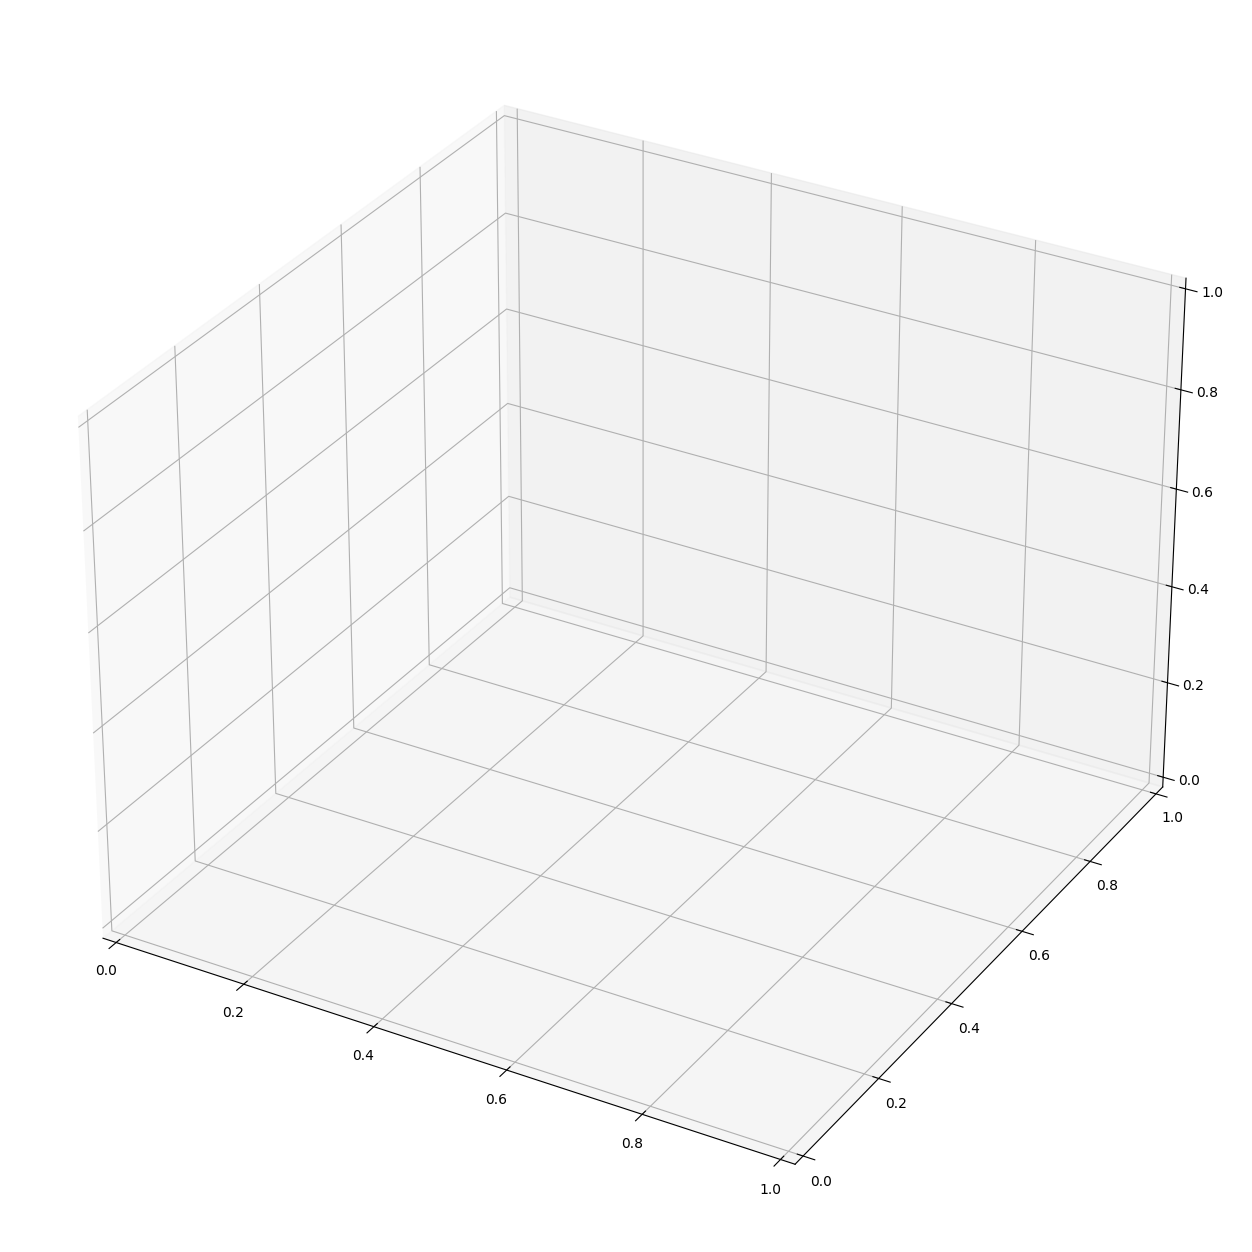

In [6]:
# Graph
# run in google collab requires high ram capacity due to the mplot3d graph
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(16, 16))#, dpi=150)
ax = fig.add_subplot(111,projection='3d')

#plot data
ax.plot(np.array(X_test[["cycle"]]), np.zeros_like(X_test["cycle"]), np.array(y_test), color='blue', label='Actual')
ax.plot(np.array(X_test[["cycle"]]), np.ones_like(X_test["cycle"]), np.array(poly_lstm), color='green', label="Poly+Lstm")
ax.plot(np.array(X_test[["cycle"]]), 2*np.ones_like(X_test["cycle"]), np.array(rfr_lstm), color='violet', label="Rfr+Lstm")
ax.plot(np.array(X_test[["cycle"]]), 3*np.ones_like(X_test["cycle"]), np.array(rfr_pred), color='orange', label="Rfr")
ax.plot(np.array(X_test[["cycle"]]), 4*np.ones_like(X_test["cycle"]), np.array(poly_pred), color='purple', label="Poly")
ax.plot(np.array(X_test[["cycle"]]), 5*np.ones_like(X_test["cycle"]), np.array(lstm_pred), color='red', label="lstm")




# graph properties

ax.set_xlabel("Cycle")
ax.set_ylabel("    Method")
ax.set_zlabel("SOH")
ax.set_yticks([0, 1, 2, 3, 4, 5])
ax.set_yticklabels(['actual', 'Poly+Lstm', 'Rfr+lstm', 'Rfr', 'Poly','Lstm'])
ax.set_title("Comparison Graph")

plt.legend(loc="upper right")
plt.show()